In [44]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

------
------

# 1. EDA

## 0) get DataFrame

In [6]:
### 1> set several paths
PATH_TRAIN = 'train.csv'
PATH_TEST = 'test.csv'

### 2> read_csv
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


------

## 1) the distribution of target

In [9]:
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

-------

## 2) What stopwords are used frequently?

In [10]:
df_train.loc[df_train['target'] == 1, 'text'].str.split()

0       [Our, Deeds, are, the, Reason, of, this, #eart...
1          [Forest, fire, near, La, Ronge, Sask., Canada]
2       [All, residents, asked, to, 'shelter, in, plac...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, this, photo, from, Ruby, #Al...
                              ...                        
7608    [Two, giant, cranes, holding, a, bridge, colla...
7609    [@aria_ahrary, @TheTawniest, The, out, of, con...
7610    [M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...
7611    [Police, investigating, after, an, e-bike, col...
7612    [The, Latest:, More, Homes, Razed, by, Norther...
Name: text, Length: 3271, dtype: object

### 1> 해당 target 값을 가지는 text들 중 사용되는 단어들을 리스트로 만드는 함수

In [21]:
def make_list_by_target(target):
    corpus = []
    
    for x in df_train.loc[df_train['target'] == target, 'text'].str.split():
        # x에는 각 idx별 text_data가 들어간다.
        for i in x:
            # i에는 각 text_data별 단어들이 들어간다. 
            corpus.append(i)
            
    return corpus

### 2> stopword

stopword (불용어): 자주 등장하지만 분석을 하는 것에 있어서는 큰 도움이 되지 않는 단어

In [22]:
from nltk.corpus import stopwords

In [23]:
stop = set(stopwords.words('english'))

### 3> disaster data (target == 0) 중에서 단어의 사용 빈도 조사

In [24]:
from collections import defaultdict

<BarContainer object of 10 artists>

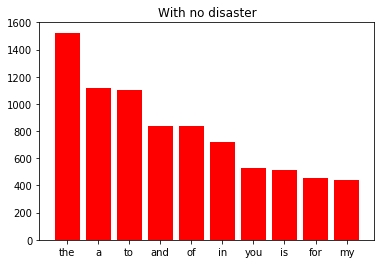

In [30]:
corpus = make_list_by_target(0)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top)
plt.title('With no disaster')
plt.bar(x, y, color = 'red')

### 4> non-disaster data (target == 1) 중에서 단어의 사용 빈도 조사

<BarContainer object of 10 artists>

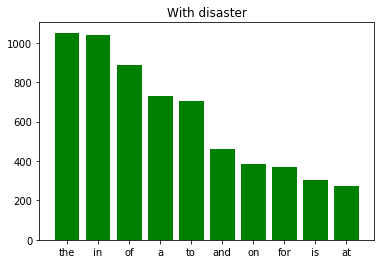

In [26]:
corpus = make_list_by_target(1)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top)

plt.title('With disaster')
plt.bar(x, y, color='green')

#### 결론: 보통 재난 상황에서는 본인의 위치('in')을 설명하려고 한다.

--------

## 3) Check Punctuation (구두점 확인)

### 1> disaster data (target == 0) 중에서 구두점의 사용 빈도 조사

In [28]:
import string

<BarContainer object of 20 artists>

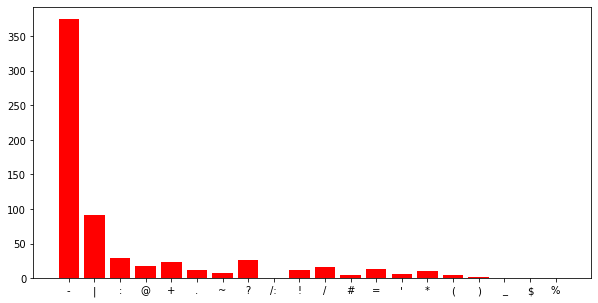

In [40]:
plt.figure(figsize=(10, 5))
corpus = make_list_by_target(0)

dic = defaultdict(int)

special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y, color = 'red')

### 2> non-disaster data (target == 1) 중에서 구두점의 사용 빈도 조사

해당 빈도가 유사하니 추후 구두점을 그냥 제거해도 될 것 같다.

<BarContainer object of 18 artists>

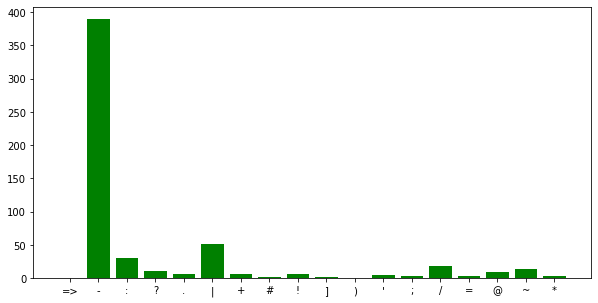

In [37]:
plt.figure(figsize=(10, 5))
corpus = make_list_by_target(1)

dic = defaultdict(int)

special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y, color='green')

----------

## 4) Check Corpus

### 1> disaster data (target == 0) 중에서 corpus의 사용 빈도 조사

In [42]:
from collections import Counter

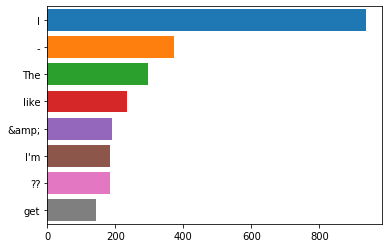

In [45]:
counter = Counter(make_list_by_target(0))
most_common = counter.most_common()

x = list()
y = list()

for word, count in most_common[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y, y=x, saturation=1)

### 2> disaster data (target == 1) 중에서 corpus의 사용 빈도 조사

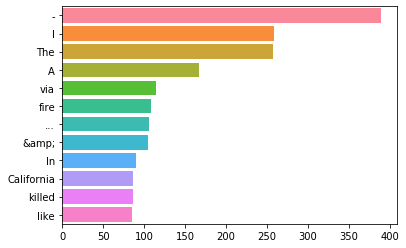

In [46]:
counter = Counter(make_list_by_target(1))
most_common = counter.most_common()

x = list()
y = list()

for word, count in most_common[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y, y=x, saturation=1)

------

## 5) Check Bigram

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
def get_top_tweet_bigrams(corpus, n=10):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

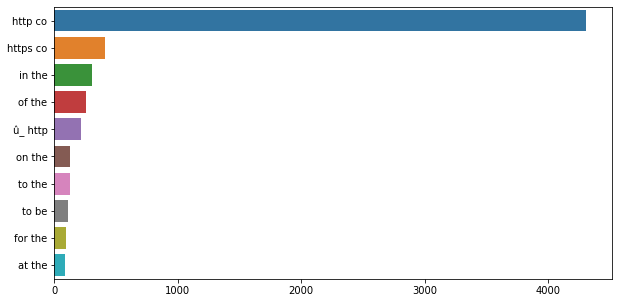

In [52]:
plt.figure(figsize=(10, 5))
top_tweet_bigrams = get_top_tweet_bigrams(df_train['text'])[:10]

x, y = map(list, zip(*top_tweet_bigrams))

sns.barplot(x=y, y=x)